In [1]:
import os
import sys
import matplotlib.pyplot as plt

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'BlackBox_Attack'))

In [2]:
from attack import *

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-07-29 17:31:23.939401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-29 17:31:25.437950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from TabNet import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

In [4]:
data = pd.read_csv('../../../Dataset/cybersecurity_intrusion_data.csv')
# data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'responh'])
has_failed_logins = []
for i in data['failed_logins']:
    if i:
        has_failed_logins.append(1)
    else:
        has_failed_logins.append(0)

data['has_failed_logins'] = has_failed_logins
data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})
data['attack_detected'] = data['attack_detected'].replace({0: 1, 1: 0})
data.head()

/tmp/ipykernel_350239/1412528349.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
/tmp/ipykernel_350239/1412528349.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,has_failed_logins
0,SID_00001,599,1,4,492.983263,1.0,0.606818,1,Edge,0,0,1
1,SID_00002,472,1,3,1557.996461,1.0,0.301569,0,Firefox,0,1,0
2,SID_00003,629,1,3,75.044262,1.0,0.739164,2,Chrome,0,0,1
3,SID_00004,804,2,4,601.248835,1.0,0.123267,0,Unknown,0,0,0
4,SID_00005,453,1,5,532.540888,0.0,0.054874,1,Firefox,0,1,1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [6]:
data = data.dropna(axis=1)

In [7]:
def normalize_feature_name(feat_name: str) -> str:
    import re
    # Remove binning patterns like "0.1 < feature <= 3.2", "feature = 1", etc.
    return re.sub(r'([<>]=?|=)\s*[-+]?\d+(\.\d+)?', '', feat_name).strip()

In [8]:
protected_feature = 'has_failed_logins'
protected_feature = normalize_feature_name(protected_feature)

In [9]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='attack_detected',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling ALL numerical features as requested (scale_all_features=True).
Features actually being scaled: ['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'has_failed_logins']


In [10]:
numerical_features = ['network_packet_size',
 'protocol_type',
 'login_attempts',
 'session_duration',
 'encryption_used',
 'ip_reputation_score',
 'failed_logins',
 'unusual_time_access']

In [11]:
feature_names = list(x_train.columns[:])
class_names = ['Malicious', 'Benign']
feature_names

['network_packet_size',
 'protocol_type',
 'login_attempts',
 'session_duration',
 'ip_reputation_score',
 'failed_logins',
 'unusual_time_access',
 'has_failed_logins']

In [12]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [13]:
categorical_features_indices = get_categorical_feature_indices(x_train.columns, numerical_features)
categorical_features = list(x_train.columns[:][categorical_features_indices])
categorical_features

['has_failed_logins']

In [14]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# For testing data
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 2 # Changed to a smaller size for demonstration with small dataset

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Accuracy: 0.8630328441649197
Precision: 0.8820149848661193
Recall: 0.8630328441649197
F-1: 0.8594166810549156


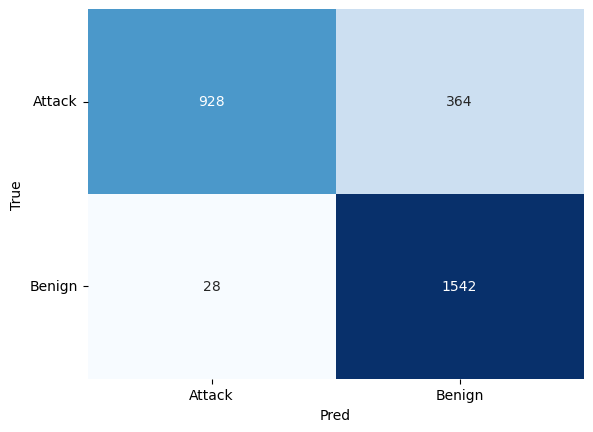

In [15]:
biased_model = base_model_call(
    x_train=x_train,
    y_train=y_train,
    protected_feature=protected_feature,
    keep_protected_feature=True,
    num_epochs=50,
    hidden_sizes=[128, 64],
    dropout_rate=0.3
)
y_pred_biased_model = biased_model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_biased_model)

In [16]:
attacker = BlackBoxIInterpretationAttack(
    target_model=biased_model.pytorch_model,
    generate_explanation_func=lambda m, x, c: my_tabular_explanation_function(m, x, c, 'integrated_gradients'),
    scaler=scaler, # Pass the fitted scaler
    scaled_feature_names=feature_names, # All feature names were scaled
    all_feature_names=feature_names, # All original feature names
    numerical_feature_names_for_perturbation=numerical_features, # All are perturbable
    categorical_feature_names=categorical_features, # Empty list for Iris
    device='cpu'
)


Features allowed for perturbation: ['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']
Categorical features (will not be perturbed): ['has_failed_logins']


In [17]:
results, asr = attacker.run_attack(test_dataloader, num_samples_to_attack=50, C=0.1)
print(f"Final Attack Success Rate: {asr:.2%}")


Starting attack...


Collected 100 samples and explanations in 7.75 seconds.
Approximating manifolds with UMAP...


/home/jn/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jn/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Manifolds approximated in 7.14 seconds.
  Attack for sample 1/50 took 92.29s, Success: False
  Attack for sample 2/50 took 133.35s, Success: False
  Attack for sample 3/50 took 850.95s, Success: False
  Attack for sample 4/50 took 883.55s, Success: False
  Attack for sample 5/50 took 170.55s, Success: False
  Attack for sample 6/50 took 129.15s, Success: False
  Attack for sample 7/50 took 130.10s, Success: False
  Attack for sample 8/50 took 163.16s, Success: False
  Attack for sample 9/50 took 137.22s, Success: False
  Attack for sample 10/50 took 193.62s, Success: False
  Attack for sample 11/50 took 670.17s, Success: False
  Attack for sample 12/50 took 254.09s, Success: False
  Attack for sample 13/50 took 185.17s, Success: False
  Attack for sample 14/50 took 269.13s, Success: False
  Attack for sample 15/50 took 787.78s, Success: False
  Attack for sample 16/50 took 336.66s, Success: False
  Attack for sample 17/50 took 133.03s, Success: False
  Attack for sample 18/50 took 210.

KeyboardInterrupt: 

In [ ]:
if attacker.attack_results: # Check if any successful attacks were stored
    print(f"\nFound {len(attacker.attack_results)} successful attacks.")

    # Plot each successful attack with and without target explanation
    for i, (original, x_adv, target_exp, result) in enumerate(attacker.attack_results):
        print(f"\n--- Plotting for Successful Attack {i+1} (Index {i}) ---")

        print(f"Plotting for Attack Index {i} WITHOUT target explanation.")
        attacker.plot_attack_result(i, include_target_explanation_plot=False)

        print(f"Plotting for Attack Index {i} WITH target explanation.")
        attacker.plot_attack_result(i, include_target_explanation_plot=True)

else:
    print("\nNo successful attack found to visualize. Try increasing num_samples_to_attack or adjusting C or max_iter.")


No successful attack found to visualize. Try increasing num_samples_to_attack or adjusting C or max_iter.
